# Predicting house prices using k-nearest neighbors regression
In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

# Fire up GraphLab Create

In [1]:
import pandas as pd
import numpy as np # note this allows us to refer to numpy as np instead

# Load in house sales data

**1.** For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 
              'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 
              'id':str, 'sqft_lot':int, 'view':int}
sales = pd.read_csv('./kc_house_data_small.csv', dtype=dtype_dict)
print "\nNumber of features = %d" %len(sales.columns)
sales.head(2)


Number of features = 21


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0


# Import useful functions from previous notebooks

**2.** If you’re using Python: To do the matrix operations required to perform k nearest neighbors, we will be using the popular python library ‘numpy’ which is a computational library specialized for operations on arrays.

**3.** To efficiently compute pairwise distances among data points, we will convert the SFrame (or dataframe) into a 2D Numpy array. First import the numpy library and create a get_numpy_data() (or equivalent) function that takes a dataset, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]) to be used as inputs, and a name of the output (e.g. ‘price’). It returns a ‘features_matrix’ (2D array) consisting of a column of ones followed by columns containing the values of the input features in the data set in the same order as the input list. It also returns an ‘output_array’, which is an array of the values of the output in the dataset (e.g. ‘price’).

In [3]:
# get_numpy_data(    data_pdframe,   features,   output):

# inputs
# a pandas dataframe, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), 
# and name of the output/response column (e.g. ‘price’)

# ouputs
#  ‘feature_matrix’ (2D array)
#  an ‘output_array’ which is an array of the values of the output in the data set (e.g. ‘price’)

# Call like this, collecting return data in a tuple
# (example_features, example_output) =  get_numpy_data(sales, ['sqft_living'], 'price')
# NB., sales is the pdFrame, features_list = ['sqft_living', ....], response = 'price')
   
#we don't really need to add a constant 1 col and will get same results with or without constant=1 col
def get_numpy_data(data_pdframe, features, output):
    
    data_pdframe['constant'] = 1 # this is how you add a new column to an dataframe
    
    # add the column 'constant' to the FRONT of the features list 
    # so that we can extract it along with the others:
    features = ['constant'] + features # add two lists
    
    #NB features = 'constant' + features  wont work!! - can't add string constant to a list
    
    #print "get_numpy_data(): Features", features, "\n"  
    
    # select the columns of data_pdFrame given by the features list 
    # into the pdFrame features_pdframe (now including constant 1 col):
    features_pdframe = data_pdframe[features]
    
    print "get_numpy_data(): print features_pdframe(head(2)\n",features_pdframe.head(2), "\n"  
    #prints the 2 columns n its values, constant and sqft_living
    
    # Convert the pdframe to its Numpy-array representation.
    # feature_matrix = features_sframe.to_numpy()    #if sframe , use .to_numpy()
    feature_matrix = features_pdframe.as_matrix()    #if pdframe ,use .as_matrix() 
    len(feature_matrix)
    print "get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]\n",feature_matrix[0:2, :] , "\n" 
    
    # assign the column of data_pdframe associated with the output to the SArray output_sarray
    output_sarray = data_pdframe[output]
    print "get_numpy_data(): data_pdframe['price']\n", output_sarray.head(2), "\n"
    
    # Convert the pdframe column - a series to its Numpy-array representation.
    # output_array = output_sarray.to_numpy()   #if column is sframe column  i.e a sarray
    output_array = output_sarray.as_matrix()    #if column is pdframe column i.e a series
    print "get_numpy_data(): data_pdframe['price'].as_matrix()\n", output_array[0:2], "\n"
    
    return(feature_matrix, output_array)

**4.** In the house dataset, features vary wildly in their relative magnitude: sqft_living is very large overall compared to bedrooms, for instance. In computing distances, it is crucial to normalize features. Otherwise, for example, the sqft_living feature (typically on the order of thousands) would exert a much larger influence on distance than the bedrooms feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

To give equal considerations for all features, we need to normalize features: we divide each feature by its 2-norm so that the transformed feature has norm 1. Given a feature matrix, each column is divided (element-wise) by its 2-norm. The function returns two items: (i) a feature matrix with normalized columns and (ii) the norms of the original columns.

In [4]:
# divide each feature by its 2-norm, axis=0 --> columns, so divide values in column by its 2-norm
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)    
    normalized_features = feature_matrix/ norms
    
    return  (normalized_features, norms)

# Split data into training, test, and validation sets

**5.** Using get_numpy_data (or equivalent), extract numpy arrays of the training, test, and validation sets - will do this after we split data into train, validate and test sets. Since we not using graphlab, we are provided dat sets that are already split so as to get reproducible results to those using graphlab create.

In [5]:
train = pd.read_csv('./kc_house_data_small_train.csv', dtype=dtype_dict)
validation = pd.read_csv('./kc_house_data_small_validation.csv', dtype=dtype_dict)
test = pd.read_csv('./kc_house_data_small_test.csv', dtype=dtype_dict)

# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation SFrames into Numpy arrays: (NB **Nearest Neihbour only works with numerical features!!!  really...**)

In [6]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

get_numpy_data(): print features_pdframe(head(2)
   constant  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0         1       3.0       1.00       1180.0      5650     1.0           0   
1         1       3.0       2.25       2570.0      7242     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      7        2170            400      1951          1991   

       lat     long  sqft_living15  sqft_lot15  
0  47.5112 -122.257         1340.0      5650.0  
1  47.7210 -122.319         1690.0      7639.0   

get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]
[[  1.00000000e+00   3.00000000e+00   1.00000000e+00   1.18000000e+03
    5.65000000e+03   1.00000000e+00   0.00000000e+00   0.00000000e+00
    3.00000000e+00   7.00000000e+00   1.18000000e+03   0.00000000e+00
    1.95500000e+03   0.00000000e+00   4.75112000e+01

**6.** In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We **divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.**

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [7]:
print test[feature_list].head(1)     #test sframe 1st row - 17 features
print features_test[0,:]             #test 2D matrix 1st row - 18 values!!!
#NB feature_test matrix has extra const col of 1's so 17 features plus const gives size 18 vector

# normalize training set features (columns)
features_train, norms = normalize_features(features_train) 
print (features_test[0,:]/norms)

# normalize test set and validation set by same training set norms
features_test = features_test / norms 
features_valid = features_valid / norms 

   bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       4.0        3.0       2950.0      5000     2.0           0     3   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      9        1980            970      1979             0   

       lat     long  sqft_living15  sqft_lot15  
0  47.5714 -122.375         2140.0      4000.0  
[  1.00000000e+00   4.00000000e+00   3.00000000e+00   2.95000000e+03
   5.00000000e+03   2.00000000e+00   0.00000000e+00   3.00000000e+00
   3.00000000e+00   9.00000000e+00   1.98000000e+03   9.70000000e+02
   1.97900000e+03   0.00000000e+00   4.75714000e+01  -1.22375000e+02
   2.14000000e+03   4.00000000e+03]
[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345387 -0.01346922  0.01375926  0.0016225 ]


# Compute a single distance

**7.** To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector (17 features plus response 'price') whose components are between 0 and 1.

In [8]:
# features_test[:,0]    this is 1st column idiot
# print len(features_test[:,0]) gave 1741
features_test[0,:]    #this is 1st row   - NB the ,: can be dropped if we not splicing the columns
# NB this is just 1st row of obs from test data set with only features given above that had been normalized 
print len(features_test[0,:]) #len(features_test = 1741
print features_test[0]        #shud be same as what we got above code segment

18
[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345387 -0.01346922  0.01375926  0.0016225 ]


Now print the 10th row (index 9) of the training feature matrix. Again, you get an 18-dimensional vector with components between 0 and 1.

In [9]:
features_train[9,:]            #this is 10th row  - index 9
print len(features_train[9,:]) #len(features_train)=5527
print features_train[9] 

18
[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346251  0.01195898  0.00156612]


***QUIZ QUESTION ***

**8.** What is the Euclidean distance between the query house and the 10th house of the training set? 

Note: Do not use the `np.linalg.norm` function; use `np.sqrt`, `np.sum`, and the power operator (`**`) instead. The latter approach is more easily adapted to computing multiple distances at once. So we do sum of squares of feature-wise differences between test obs and train obs, then sqrt. 

In [10]:
#element-wise differences between 1st row test aad 10th row train
print  (features_train[9,:] - features_test[0,:])   
diff = (features_train[9,:] - features_test[0,:])

diff_sum_of_squares = np.sum(diff**2)      #sum of squares of differences
eucl_dist = np.sqrt(diff_sum_of_squares)   #sqrt() of squared sum - bit like the 2 norm!!!
print eucl_dist

[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -9.24331842e-03
  -1.09762322e-03  -4.26475103e-03   0.00000000e+00  -5.10236549e-02
   7.75473450e-03  -1.73816863e-03  -3.98994223e-03  -2.48168183e-02
  -4.77622244e-04   0.00000000e+00   1.43386859e-05   6.71397301e-06
  -1.80027678e-03  -5.63818921e-05]
0.059723593714


In [11]:
print np.sqrt(np.sum( (features_train[9,:] - features_test[0,:])**2 ))

print np.sqrt(np.sum( (features_train[9] -   features_test[0])**2 ))

0.059723593714
0.059723593714


# Compute multiple distances

**9.** Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set. Because we want to **find the shortest distance between test obs and all of train obs**, so we need to find all distances and then min dist as being nearest neighbour in train set to our test obs.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [12]:
dist = list(xrange(10))
for i in xrange(10):
    dist[i] = np.sqrt(np.sum( (features_train[i] - features_test[0])**2 ))
    print i, " : ", dist[i]

0  :  0.060274709163
1  :  0.0854688114764
2  :  0.0614994643528
3  :  0.0534027397929
4  :  0.0584448406017
5  :  0.0598792150981
6  :  0.0546314049678
7  :  0.0554310832361
8  :  0.0523836278402
9  :  0.059723593714


*** QUIZ QUESTION ***

**10.** Among the first 10 training houses, which house is the closest to the query house?

In [13]:
print np.min(dist)    #the 9th house from visual inspection above
print('%dth house' % (np.argmin(dist) + 1))  #np.argmin() gives index which starts at 0

0.0523836278402
9th house


**11.** It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

Consider the following loop that computes the **element-wise difference between the features**of the query house (`features_test[0]`) and the first 2 training houses (`features_train[0:2]`):

In [14]:
for i in xrange(2):
    print features_train[i]-features_test[0], "\n"
    #dist[i] = np.sqrt(np.sum( (features_train[i] - features_test[0])**2 ))
    #print dist[i]
    # should print 2 vectors (one for each training house) of length 18
    # there are 18 features for a row, so 18 element wise differences, 
    # one for each difference between test and each train row
    # NB 1st col is const 1 so same for both train and test - thus diff always 0
    # THis thus implies that the distance computed is sum of absolute differences over all features
    # so we don't have feature wise differences!! don't know wht am saying here...

[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -1.05552733e-02
   2.08673616e-04  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
   0.00000000e+00  -3.47633726e-03  -5.50336860e-03  -2.48168183e-02
  -1.63756198e-04   0.00000000e+00  -1.70254220e-05   1.29876855e-05
  -5.14364795e-03   6.69281453e-04] 

[  0.00000000e+00  -3.87821276e-03  -4.51868214e-03  -2.26610387e-03
   7.19763456e-04   0.00000000e+00   0.00000000e+00  -5.10236549e-02
   0.00000000e+00  -3.47633726e-03   1.30705004e-03  -1.45830788e-02
  -1.91048898e-04   6.65082271e-02   4.23090220e-05   6.16364736e-06
  -2.89330197e-03   1.47606982e-03] 



The subtraction operator (`-`) in Numpy is vectorized as follows: Here we compute the element-wise difference between the features of the query house (features_test[0]) and the first 2 training houses (features_train[0:2]) in one line, and just by giving a row splice [0:2] of train set!! too easy man...

In [15]:
print features_train[0:2] - features_test[0]

[[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -1.05552733e-02
    2.08673616e-04  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03  -5.50336860e-03  -2.48168183e-02
   -1.63756198e-04   0.00000000e+00  -1.70254220e-05   1.29876855e-05
   -5.14364795e-03   6.69281453e-04]
 [  0.00000000e+00  -3.87821276e-03  -4.51868214e-03  -2.26610387e-03
    7.19763456e-04   0.00000000e+00   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03   1.30705004e-03  -1.45830788e-02
   -1.91048898e-04   6.65082271e-02   4.23090220e-05   6.16364736e-06
   -2.89330197e-03   1.47606982e-03]]


Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [16]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print results[0] - ( features_train[0]-features_test[0] )
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print results[1] - ( features_train[1]-features_test[0] )
# should print all 0's if results[1] == (features_train[1]-features_test[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Aside: it is a good idea to write tests like this cell whenever you are vectorizing a complicated operation.

# Perform 1-nearest neighbor (1-NN) regression

**12.** Now that we have the element-wise differences, it is not too hard to **compute the Euclidean distances between our query house and all of the training houses**. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house. So we just calculate element wise differences between test and all observations in training.

In [17]:
diff = features_train[0:len(features_train)] - features_test[0]

#18 element-wise feature by feature difference between the query and last training house
print diff[len(features_train) - 1]  

# sum of the feature differences between the query and last training house
np.sum ( diff[ len(features_train) - 1]  ) 

[  0.00000000e+00  -3.87821276e-03  -3.01245476e-03  -8.46807236e-03
  -1.24208957e-03   8.52950206e-03   0.00000000e+00  -5.10236549e-02
   0.00000000e+00  -1.73816863e-03  -3.09564484e-03  -2.48168183e-02
   2.04695248e-04   0.00000000e+00   3.61719513e-05   3.19188881e-06
  -3.92203156e-03  -1.01041218e-03]


-0.093433998746546426

To test the code above, run the following cell, which should output a value -0.0934339605842:

In [18]:
print len(features_train)
# sum of the feature differences between the query and last training house
# diff[-1] is the feature wise diff between query and last train house
print diff[-1].sum() 
print np.sum(diff[-1])
# both above should print -0.0934339605842

5527
-0.0934339987465
-0.0934339987465


**13.** The next step in **computing the Euclidean distances** is to take these feature-by-feature differences in `diff`, square each, and take the sum over 18 feature indices.  That is, **compute the sum of square of feature differences** for each training house (row in `diff`).

By default, **`np.sum` sums up everything in the matrix and returns a single number!!**. To instead **sum only over a row or column, we need to specifiy the `axis` parameter** described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, **`axis=1` computes the sum across each row** - this is what we want in this case, because each row contains the element-wise feature diffences..

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone. 

In [19]:
print np.sum(diff**2, axis=1)[15] # take sum of squares across each row, and print the 16th sum
print np.sum(diff[15]**2) # print the sum of squares for the 16th row -- should be same as above

print (diff[15]**2).sum() == np.sum(diff[15]**2)

0.00330705902846
0.00330705902846
True


**14.** With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

**Hint**: Do not forget to take the square root of the sum of squares.

In [20]:
distances = np.sqrt(np.sum(diff**2, axis=1))
# distances = np.sqrt(np.sum(diff**2, axis=1)[0:len(features_train)])

To test the code above, find the Euclidean distance between the query house and the 101th training house, which should output a value 0.0237082324496:

In [21]:
print distances[100] 
# should print 0.0237082324496

0.0237082324167


**15.** Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [22]:
def compute_distances(features_instances, features_query):
    diff = features_instances - features_query
    distances = np.sqrt(  np.sum(diff**2, axis=1))
    return distances

# Note don't really size or length of train set cause when we leave out row splicing [:]
# the whole set of samples is taken, i.e no subsets taken 
# size = len(features_instances)    <-- this just finds how many samples in train set
# diff = features_instances[0:size] - features_query

*** QUIZ QUESTIONS 16. and 17. ***

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?   382
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [23]:
distances = compute_distances(features_train, features_test[2])
print min(distances)                  # whats the shortest Euclidean dist
min_index = np.argmin(distances)      # index of the shortest Euclidean dist item in numpy array
print distances[np.argmin(distances)] # verify 
print('%dth house' % (min_index + 1))

0.00286049555751
0.00286049555751
383th house


In [24]:
# NB with sframes to get value of feature for certain row we did  test[2]['price']
# But with pandas dataframe, we have to specify feature col name 1st, then row index
print "Actual value of the query house = $%d" %test['price'][2]
print "Predicted value of the query house = $%d" %train['price'][min_index] 
print "Error of $%d" %(test['price'][2] - train['price'][min_index])

Actual value of the query house = $438000
Predicted value of the query house = $249000
Error of $189000


# Perform k-nearest neighbor regression

**18.** So far we have a single house in training set that is closest in distance to our test house, so just 1-NN, but results from 1-NN although having good fit for data dense in x and low noise, not great at interpolating over large regions, also sensitive to noise in data - fits can look quite wild. For k-nearest neighbors, we need to find a *set* of k houses in the training set that are closest to a given query house. We then make predictions based on these k nearest neighbors, by finding mean value of these k houses in train set.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).   

'numpy.argsort(a, axis=-1, kind='quicksort', order=None)' 

Returns the indices that would sort an array, rather then give sorted values, it gives indices of sorted values... great!!!

In [25]:
# don't need to reinvent tool - use compute_distances() we already wrote earlier
# we sort distances in ascending order and pick 1st k samples as our closest neighbours
def k_nearest_neighbors(k, feature_train, features_query):
    distances = compute_distances(features_train, features_query)
    neighbors = np.argsort(distances)[0:k]   
    return neighbors

*** QUIZ QUESTION 19. ***

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

In [26]:
knn_2 =  k_nearest_neighbors(4, features_train, features_test[2])
print knn_2, "\n\n"

print "Predicted price using mean price of nehbours = $%d" %np.mean(output_train[knn_2])

[ 382 1149 4087 3142] 


Predicted price using mean price of nehbours = $413987


## Make a single prediction by averaging k nearest neighbor outputs

**20.** Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [27]:
def predict_output_of_query(k, features_train, output_train, features_query):
    neighbors = k_nearest_neighbors(k, features_train, features_query)
    prices = output_train[neighbors]
    prediction = np.mean(prices)
    return prediction

*** QUIZ QUESTION 21. ***

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [28]:
#knn_value = k_nearest_neighbors_value(4, features_train, output_train, features_test[2])
predicted_value = predict_output_of_query(4, features_train, output_train, features_test[2])
print('Predicted Value $%s' % predicted_value)
print "Actual value of the query house = $%d" %test['price'][2]
print "Error of $%d" %(test['price'][2] - predicted_value )

Predicted Value $413987.5
Actual value of the query house = $438000
Error of $24012


Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

1-nn gave predicted value = \$249000, which was off by \$189,000. the 4_nn estimate is only out by \$24013

## Make multiple predictions

**22.** Finally, write a function to predict the value of each and every house in a query set. 
Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix.  ndarray.shape - gives Tuple of array dimensions.See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [29]:
def predict_output(k, features_train, output_train, features_query):
    predictions = []
    for i in xrange(len(features_query)):
        prediction = predict_output_of_query(k, features_train, output_train, features_query[i])
        predictions.append(prediction)
        
    return predictions

In [30]:
# This is how I did earlier without calling any of the functions we defined earlier
# see why it may not not work!!!
#def predict_output(k, features_train, output_train, features_test):
    
#    predictions = []
#    size = len(features_train)
#    (len_test,col) = features_test.shape
#    pred_value = list(xrange(len_test))
    
#    for i in xrange(len_test):
#        diff = features_train[0:size] - features_test[i]
#        distances = np.sqrt(  np.sum(diff**2, axis=1)[0:size] )
#        indices_of_sorted_distances = np.argsort(distances)
#        first_k_indices = list(indices_of_sorted_distances[0:k])
#        predictions.append(np.sum(output_train[first_k_indices])/k)
    
#    return pred_value

*** QUIZ QUESTION 23. ***

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. 

1. What is the index of the house in this query set that has the lowest predicted value? 
2. What is the predicted value of this house?

In [31]:
knn_val = predict_output(10, features_train, output_train, features_test[0:10])

print "Actual prices of 10 houses from test set\n", np.array(test[0:10]['price'])
print (test[0:10]['price']).describe()
print "\nPredicted prices of 1st 10 houses from test set using 10-NN from train data\n", (knn_val)
print pd.Series(knn_val).describe()

print "\nIndex of the house in this query set that has the lowest predicted value", np.argmin(knn_val)
print "\nLowest predicted value is $%d\n\n" %knn_val[np.argmin(knn_val)]

Actual prices of 10 houses from test set
[ 650000.  485000.  438000.  535000.  785000.  975000.  287000.  355000.
  305000.  518500.]
count        10.000000
mean     533350.000000
std      218144.453924
min      287000.000000
25%      375750.000000
50%      501750.000000
75%      621250.000000
max      975000.000000
Name: price, dtype: float64

Predicted prices of 1st 10 houses from test set using 10-NN from train data
[881300.0, 431860.0, 460595.0, 430200.0, 766750.0, 667420.0, 350032.0, 512800.70000000001, 484000.0, 457235.0]
count        10.000000
mean     544219.270000
std      170237.816761
min      350032.000000
25%      438203.750000
50%      472297.500000
75%      628765.175000
max      881300.000000
dtype: float64

Index of the house in this query set that has the lowest predicted value 6

Lowest predicted value is $350032




## Choosing the best value of k using a validation set

**24.** There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

(Depending on your computing environment, this computation may take 10-15 minutes.)


This solution from https://github.com/anindya-saha/Machine-Learning-with-Python/blob/master/Coursera-Machine-Learning-Regression/week-6-local-regression-assignment-graphlab.ipynb

In [32]:
def get_residual_sum_of_squares(predictions, output):  
    # Then compute the residuals/errors
    residual = output - predictions
    # Then square and add them up
    residual_squared = residual * residual   
    RSS = residual_squared.sum()
    return(RSS)

In [33]:
# These functions are defined earlier above - reproduced here to enable follow logic
def compute_distances(features_instances, features_query):
    diff = features_instances - features_query
    distances = np.sqrt(  np.sum(diff**2, axis=1))
    return distances

In [34]:
# For k-nearest neighbors, we need to find a set of k houses in the training set closest 
# to a given query house. We then make predictions based on these k nearest neighbors.
def k_nearest_neighbors(k, feature_train, features_query):
    distances = compute_distances(features_train, features_query)
    neighbors = np.argsort(distances)[0:k]   
    return neighbors  #returns k closest obs to given test/query obs

In [35]:
# Make a single prediction by averaging k nearest neighbor house values np.mean()
# Uses nearest neighbours found by above function
def predict_output_of_query(k, features_train, output_train, features_query):
    neighbors = k_nearest_neighbors(k, features_train, features_query)
    prices = output_train[neighbors]
    prediction = np.mean(prices)
    return prediction #returns mean price of k closest obs to given test/query obs

In [36]:
# Make multiple predictions
# Function to predict the value of each and every house in a query set. 
# returns a set of predicted values for each house in test using best k neighbours in train
def predict_output(k, features_train, output_train, features_query):
    predictions = []
    for i in xrange(len(features_query)):
        prediction = predict_output_of_query(k, features_train, output_train, features_query[i])
        predictions.append(prediction)
        
    return predictions #returns mean price of k closest obs for ALL test/query obs

In [37]:
# we want to find whick value of k produces lowesst error or RSS
rss_all = []
for k in range(1,16):   
    #Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    predicted_values = predict_output(k, features_train, output_train, features_valid)
    
    #Computes the RSS for these predictions on the VALIDATION set
    RSS = get_residual_sum_of_squares(predicted_values, output_valid)
    rss_all.append(RSS)
    
print rss_all


[105453830251561.0, 83445073504025.5, 72692096019202.562, 71946721652091.688, 69846517419718.602, 68899544353180.836, 68341973450051.094, 67361678735491.5, 68372727958976.094, 69335048668556.742, 69523855215598.828, 69049969587246.172, 70011254508263.688, 70908698869034.344, 71106928385945.156]


Another solution from https://github.com/kgrodzicki/machine-learning-specialization/blob/master/course-2-regression/notebooks/week-6-local-regression-assignment-blank.ipynb

To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

/home/vinorda/stats-R/anaconda2/envs/conda_py2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


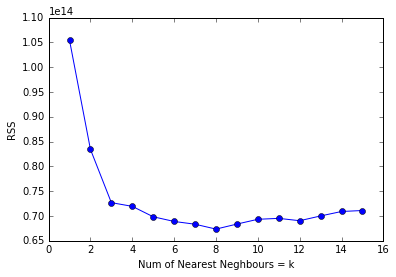

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')
plt.xlabel('Num of Nearest Neghbours = k')
plt.ylabel('RSS')
plt.legend(loc='upper left')

In [39]:
best_k = rss_all.index(min(rss_all)) + 1 # INDEX FROM 0 !
print best_k

8


***QUIZ QUESTION 25. ***

What is the RSS on the TEST data using the value of k found above?  To be clear, sum over all houses in the TEST set. Value of k for which we get lowest rss = 8, so we will look for 8 closest data points in train set for each test obs.

In [40]:
best_k = rss_all.index(min(rss_all)) + 1 # INDEX FROM 0 !

predicted_values = predict_output(best_k, features_train, output_train, features_test)
RSS = get_residual_sum_of_squares(predicted_values, output_test)
print(RSS)

1.33118823552e+14
